In [1]:
#################################################################################
# This tuitoral performs basic data processing and data analysis for dataset using seurat
# refer to https://satijalab.org/seurat/ Vignette "Guided tutorial"
# Please modify this script to apply for specific dataset.
# Usage: Rscript HCA-d_data_processing_seurat.r datasetName dataFormat
# Usage example: Rscript HCA-d_data_processing_seurat.r spleen_spleen_Madissoon2019 10X
#################################################################################

# args = argsCommand(true)
# datasetName = args[1]
# #datasetName value: organ_tissue_authorYear without space
# dataFormat = args[2]
# #dataFormat value: tsv (tab separated), 10X (sparse)

datasetName = 'BoneMarrow_BoneMarrow_HCLAdult-Bone-Marrow2'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/home/bianhaiyang/hcad/hcl/hcl_all/BoneMarrow_BoneMarrow_HCLAdult-Bone-Marrow2")
library(Seurat)
library(data.table)
library(ggplot2)
#library(flexclust)
#install.packages('flexclust')

# setwd("/path/to/dataset/")
# library(Seurat)
# library(data.table)
# library(ggplot2)
# library(flexclust)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"), h = T, row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation_hcad.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation_hcad.tsv"), h = T, sep = "\t", row.names = 1)
}
# Extract demo data for test
#data.matrix <- data.matrix[,1:500]
#data.metadata <- data.metadata[1:500,]
#data.annotation <- data.annotation[1:500,,drop=FALSE]

# Pre-processing
# Pre-processing
min.cells = 3
min.features = 0
nFeature_RNA_range = c(0, 6000)
percent.mt.thre = 25

# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
if (file.exists(paste0(datasetName,"_annotation_hcad.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}
# QC
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))

# 2. run sctransform 
#dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot
pdf(paste0(datasetName,"seurat.elbowplot.pdf"))
ElbowPlot(dataobj) 
dev.off()

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"Centering and scaling data matrix
PC_ 1 
Positive:  RNASE2, LYZ, SRGN, CD24, MS4A3, TMSB4X, VIM, PLAC8, FCN1, S100P 
	   BPI, DEFA3, FCER1G, AZU1, PGLYRP1, SERPINB1, CEACAM8, ANXA3, RETN, RNASE3 
	   CEACAM6, SLPI, DEFA4, NKG7, MPO, LTF, CRISP3, CST7, LCN2, CTSS 
Negative:  HBB, AHSP, FTH1, CA1, PRDX2, BLVRB, TFRC, HBD, HBA1, UROD 
	   IFI27, ATPIF1, GYPA, TMEM14B, HMBS, TMEM14C, CA2, REXO2, RAN, HBA2 
	   RHAG, SOD1, MPC2, S100A6, SLIRP, HSPE1, AKR1C3, GYPB, RFESD, FBXO7 
PC_ 2 
Positive:  HBA2, HBM, HBA1, SLC4A1, GYPB, GYPA, HEMGN, HBD, CA1, ALAS2 
	   HBB, AHSP, CA2, SLC25A37, HMBS, MGST3, RHCE, H1F0, PRDX2, IFI27 
	   AQP1, GYPE, PGLYRP1, LTF, BLVRB, TSPO2, CRISP3, RHD, SELENBP1, LGALS3 
Negative:  MIF, GAPDH, TMSB10, PTMA, LDHB, NPM1, B2M, MPO, PRSS57, PRTN3 
	   NUCB2, HSP90AB1, CTSG, ELANE, FABP5, PEBP1, HSPE1, BEX3, FTL, HSP90B1 
	   CALR, HSPA5, CST7, MGST1, HSPA8, HSPD1, SRGN, SSR4, AZU

png 
  2

In [2]:
pcDim = 30
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.8, n.start = 10)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6443
Number of edges: 297244

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8467
Number of communities: 14
Elapsed time: 1 seconds


In [3]:
# Visulize the clustering result
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"17:13:05 UMAP embedding parameters a = 0.9922 b = 1.112
17:13:05 Read 6443 rows and found 30 numeric columns
17:13:05 Using Annoy for neighbor search, n_neighbors = 30
17:13:05 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
17:13:06 Writing NN index file to temp file /tmp/RtmpOvzzxm/file23b679fdf5e8
17:13:06 Searching Annoy index using 1 thread, search_k = 3000
17:13:08 Annoy recall = 100%
17:13:08 Commencing smooth kNN distance calibration using 1 thread
17:13:09 Initializing from normalized Laplacian + noise
17:13:09 Commencing optimizatio

In [9]:
new.cluster.ids<-c('Blood-Connective Tissue-Neutrophil-CD24','Blood-Connective Tissue-Erythrocyte-AHSP','Blood-Connective Tissue-Erythrocyte-AHSP','Blood-Connective Tissue-Erythrocyte-AHSP','Blood-Connective Tissue-Macrophage-FCER1G CD74','Blood-Connective Tissue-Neutrophil-MPO ELANE','Blood-Connective Tissue-Neutrophil-CD24','Blood-Connective Tissue-Hemopoietic stem cell-SPINK2','Blood-Connective Tissue-Conventional dendritic cell-CD74 HLA-DRA','Blood-Connective Tissue-Plasma B Cell-JCHAIN IGKC','Blood-Connective Tissue-T Cell-CD3D','Blood-Connective Tissue-Conventional dendritic cell-CD74 HLA-DRA','Blood-Connective Tissue-Conventional dendritic cell-CD74 HLA-DRA','Blood-Connective Tissue-Hemopoietic stem cell-CD99 CD74 CD24')

In [10]:
names(new.cluster.ids) <- levels(dataobj)

In [11]:
dataobj <- RenameIdents(dataobj, new.cluster.ids)

In [12]:
hcad.label = Idents(dataobj)

In [13]:
dataobj <- AddMetaData(dataobj, metadata = hcad.label,col.name = 'hcad.label')

In [14]:
write.table(dataobj@meta.data['hcad.label'], file = paste0(datasetName,"_annotation.hcad.label.tsv"), sep = "\t", quote = F, row.names = T, col.names = T)

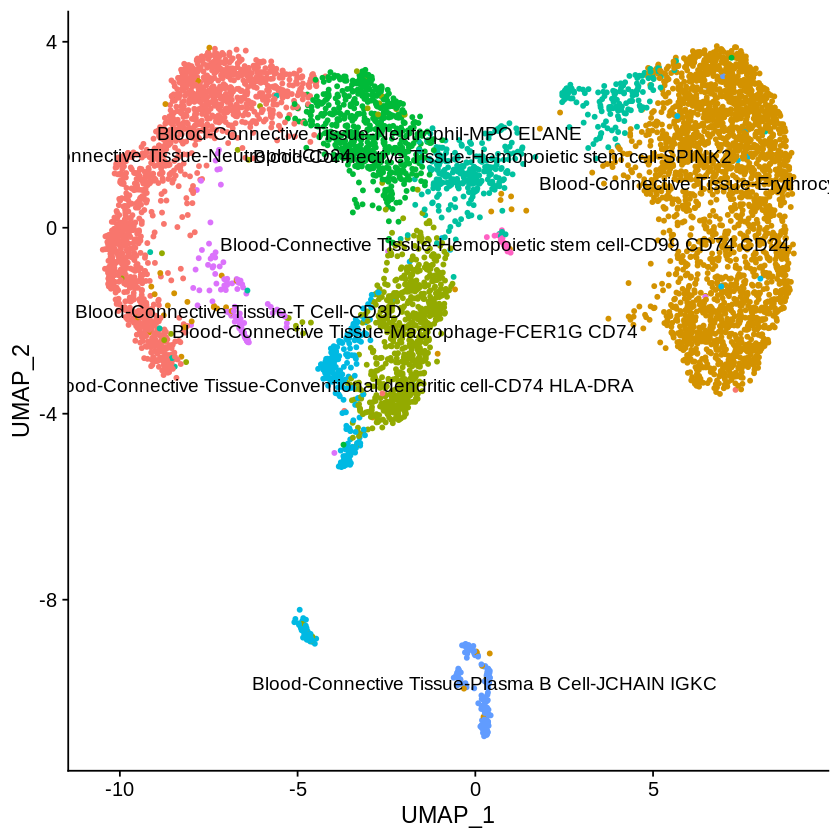

In [15]:
DimPlot(dataobj, reduction = "umap", label = TRUE, pt.size=1)+NoLegend()

In [16]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE, pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap, width = 8, height = 5)

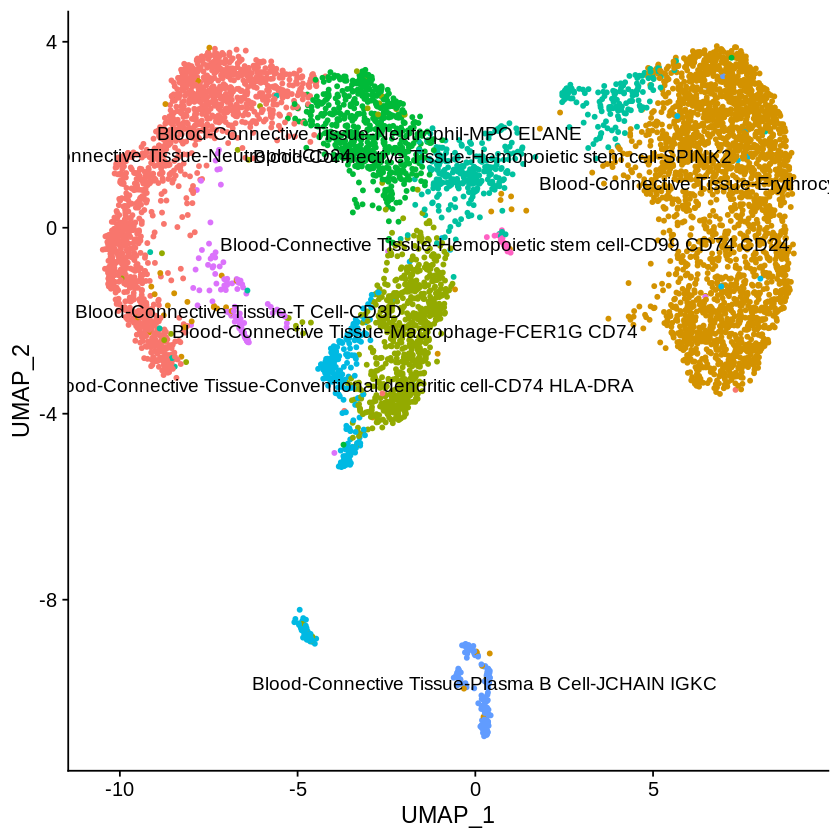

In [17]:
p_umap

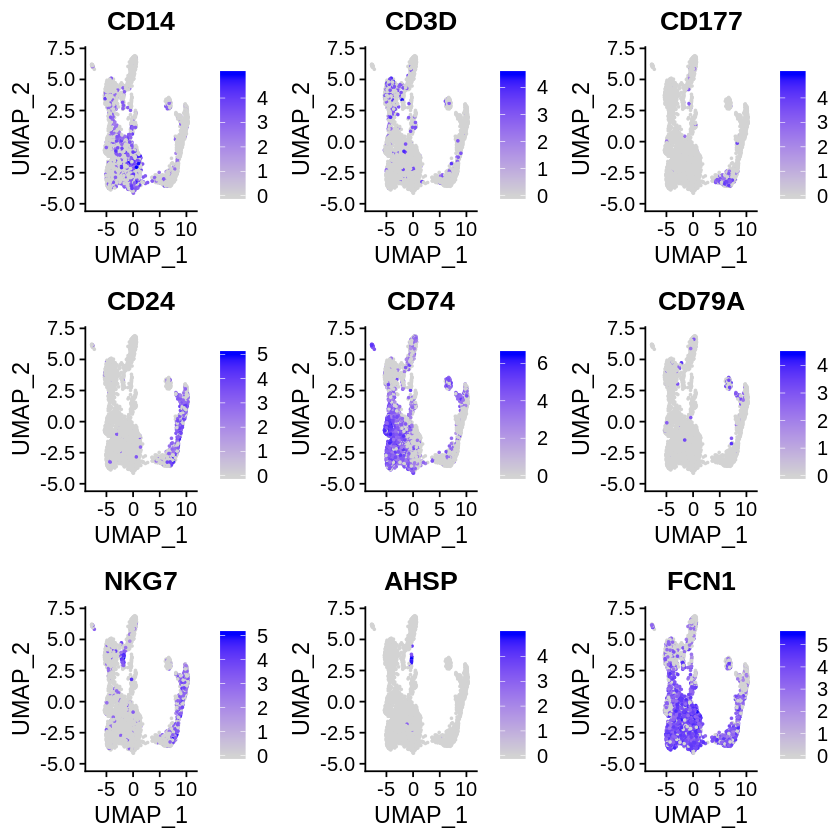

In [20]:
FeaturePlot(dataobj,features = c('CD14','CD3D','CD177','CD24','CD74','CD79A','NKG7','AHSP','FCN1'))

In [25]:
dataobj

An object of class Seurat 
13539 features across 4432 samples within 1 assay 
Active assay: RNA (13539 features)
 2 dimensional reductions calculated: pca, umap

In [14]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cluster.ids", pt.size=1)

ERROR: Error in `[[.Seurat`(object, group.by): Cannot find 'cluster.ids' in this Seurat object


In [6]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height =5)

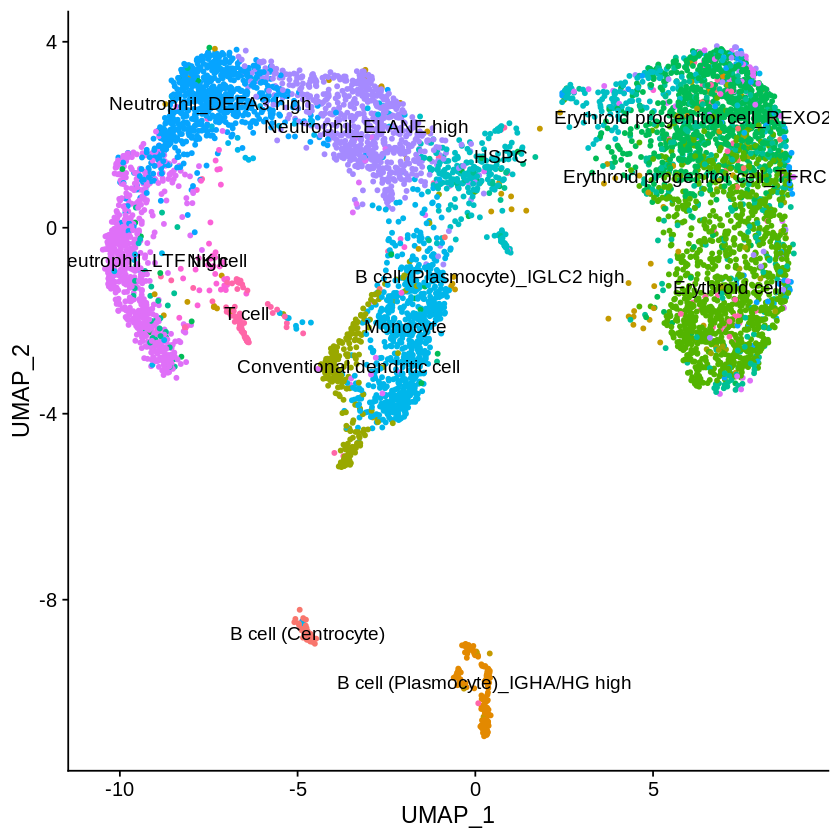

In [7]:
p_umap2

In [8]:
dataobj[['RNA']]@counts[1:5,1:5]

ERROR: Error in eval(expr, envir, enclos): object 'dataobj' not found


In [ ]:
VlnPlot(dataobj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)#+scale_color_npg() 不起作用

In [ ]:
ElbowPlot(dataobj)

In [15]:
# Compare the seurat clusters with original clusters
randIndex(dataobj$cell_cluster,dataobj$seurat_clusters)

ERROR: Error in randIndex(dataobj$cell_cluster, dataobj$seurat_clusters): could not find function "randIndex"


In [6]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1)
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height =5)
if (file.exists(paste0(datasetName,"_annotation_hcad.tsv"))) {
    p_umap3 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_ontology_class", pt.size=1)+NoLegend()
    ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap3, width = 8, height = 5)
}

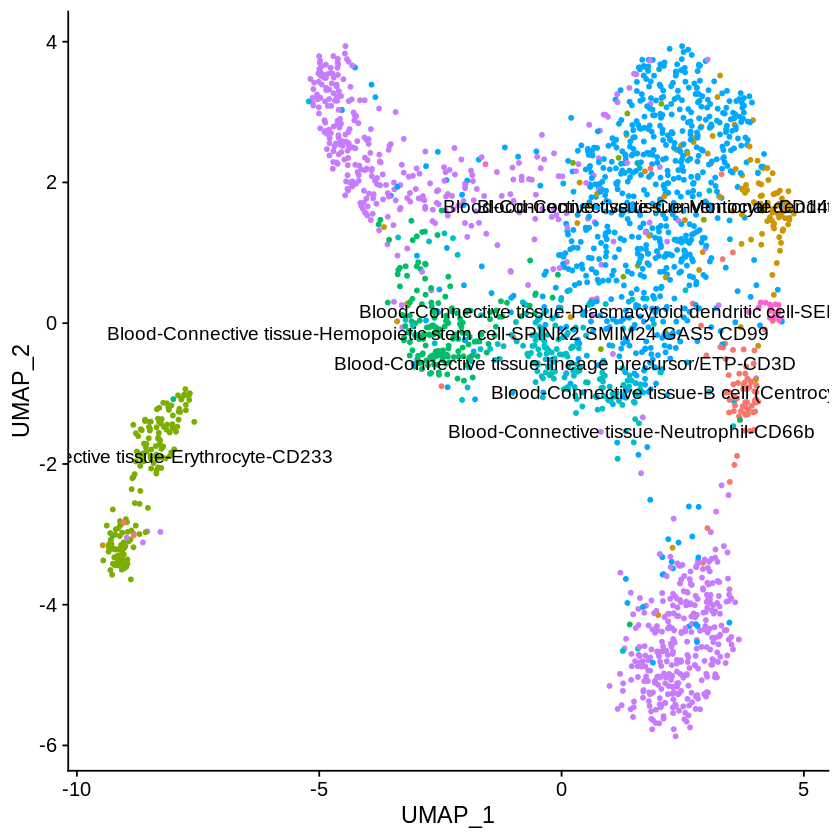

In [7]:
p_umap3

In [8]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9
Calculating cluster 10
Calculating cluster 11
Calculating cluster 12
Calculating cluster 13


In [18]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [13]:
write.table(Idents(dataobj), file = paste0(datasetName,".seurat.annotation_hcad.txt"), sep = "\t", quote = F, row.names = F, col.names = T)